In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder # OneHotEncoder is kept for robustness, though currently no categorical features
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.feature_selection import SelectKBest, f_regression # f_regression for regression tasks
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import warnings

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [3]:
print("--- 1. Loading Data ---")
try:
    # Load the full CSVs
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    # Sample 5,000 rows from train and 10,000 from test for faster execution
    # Ensure the number of samples requested does not exceed the dataframe size
    train_sample_size = min(10000, len(train_df))
    test_sample_size = min(5000, len(test_df))

    train_df = train_df.sample(n=train_sample_size, random_state=42)
    test_df = test_df.sample(n=test_sample_size, random_state=42)

    print(f"train.csv (sampled {train_sample_size} rows) and test.csv (sampled {test_sample_size} rows) loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure 'train.csv' and 'test.csv' are in the same directory as this notebook.")
    exit()

--- 1. Loading Data ---
train.csv (sampled 10000 rows) and test.csv (sampled 5000 rows) loaded successfully.


In [4]:
# Drop 'id' column as it's not a feature
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

In [5]:
# --- Define Target Variable (Continuous for Regression) ---
# For regression, the target is the continuous 'FloodProbability'
X = train_df.drop('FloodProbability', axis=1)
y = train_df['FloodProbability']
y.name = 'FloodProbability' # Explicitly set the name of the Series for clearer output

In [7]:
# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()
print(f"\nNumerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")


Numerical Features: ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors']
Categorical Features: []


In [8]:
# --- 2. Initial Data Analysis (Insights) ---
print("\n--- 2. Initial Data Analysis ---")
print("\nTrain Data Info:")
train_df.info()

print("\nTest Data Info:")
test_df.info()

print("\nTrain Data Description:")
print(train_df.describe())

print("\nMissing values in Train Data:")
print(train_df.isnull().sum())

print("\nMissing values in Test Data:")
print(test_df.isnull().sum())

print("\nDuplicate rows in Train Data:", train_df.duplicated().sum())
print("Duplicate rows in Test Data:", test_df.duplicated().sum())


--- 2. Initial Data Analysis ---

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1105809 to 730454
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 10000 non-null  int64  
 1   TopographyDrainage               10000 non-null  int64  
 2   RiverManagement                  10000 non-null  int64  
 3   Deforestation                    10000 non-null  int64  
 4   Urbanization                     10000 non-null  int64  
 5   ClimateChange                    10000 non-null  int64  
 6   DamsQuality                      10000 non-null  int64  
 7   Siltation                        10000 non-null  int64  
 8   AgriculturalPractices            10000 non-null  int64  
 9   Encroachments                    10000 non-null  int64  
 10  IneffectiveDisasterPreparedness  10000 non-null  int64  
 11  DrainageSystems           

In [9]:
# --- 3. Data Cleansing and Preprocessing Pipeline ---
# Create preprocessing pipelines for numerical and categorical features

# Numerical pipeline: Impute with median, then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: Impute with most frequent, then one-hot encode
# This transformer is included for robustness in case new categorical features appear in future data,
# but it will not affect the current numerical-only dataset.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drop columns not specified, ensuring only chosen features are processed
)

# Apply preprocessing to training data to get transformed feature names for selection
# We fit_transform X to get the column names after any potential OHE (though none expected here)
X_processed_temp = preprocessor.fit_transform(X)

# As categorical_features is empty, all_transformed_features will simply be numerical_features
all_transformed_features = numerical_features

# Convert to DataFrame for SelectKBest
X_processed_df = pd.DataFrame(X_processed_temp, columns=all_transformed_features)

print("\n--- Data Preprocessing Complete (Initial Transformation for Feature Selection) ---")
print(f"Shape after initial preprocessing: {X_processed_df.shape}")


--- Data Preprocessing Complete (Initial Transformation for Feature Selection) ---
Shape after initial preprocessing: (10000, 20)



--- 4. Exploratory Data Analysis & Visualization ---


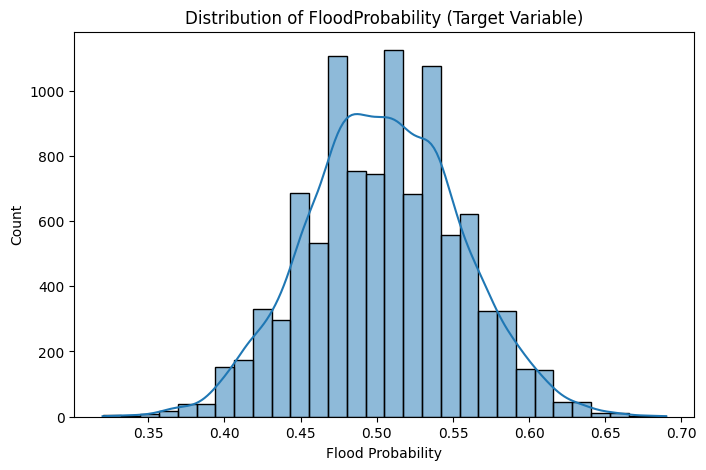


FloodProbability statistical summary:
count    10000.000000
mean         0.504403
std          0.050312
min          0.320000
25%          0.470000
50%          0.505000
75%          0.540000
max          0.690000
Name: FloodProbability, dtype: float64


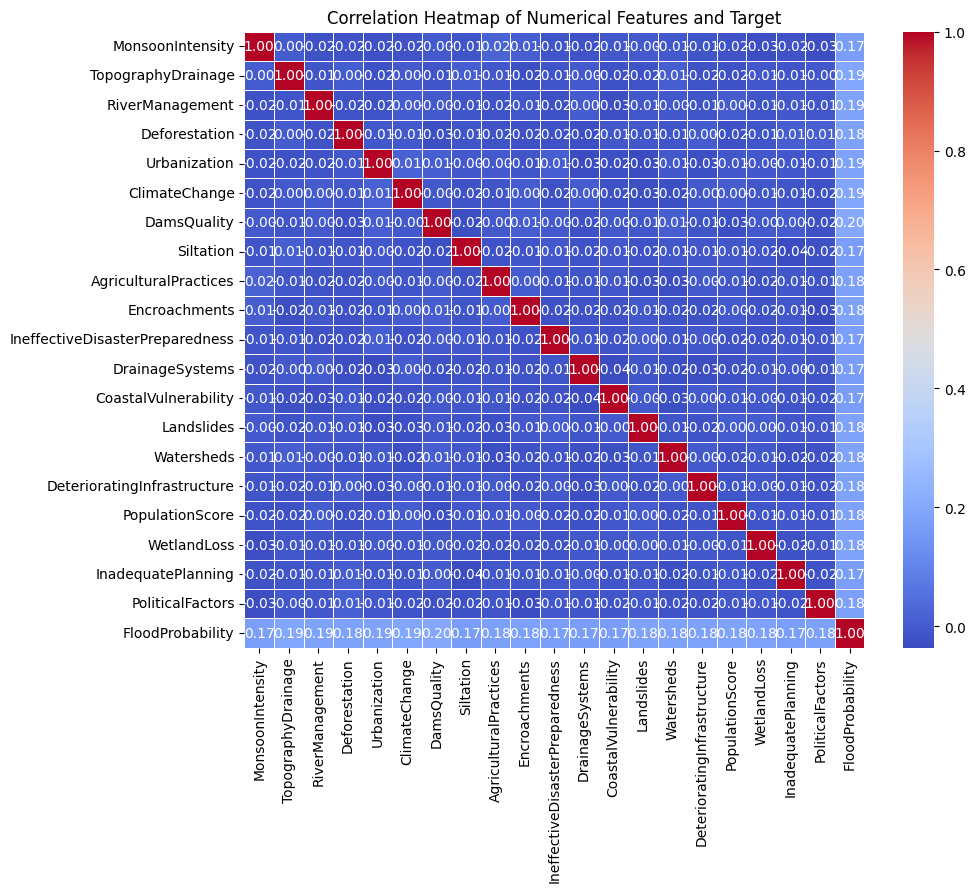


--- 5. Feature Selection (Top 10 Best Features) ---

Top 10 Selected Features: ['TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore']


In [10]:
# --- 4. EDA (Exploratory Data Analysis) & Visualization ---
print("\n--- 4. Exploratory Data Analysis & Visualization ---")

# Distribution of the continuous FloodProbability target
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=30, kde=True)
plt.title('Distribution of FloodProbability (Target Variable)')
plt.xlabel('Flood Probability')
plt.ylabel('Count')
plt.show()

print(f"\nFloodProbability statistical summary:\n{y.describe()}")

# Correlation Heatmap for numerical features (before scaling, for interpretability)
if numerical_features:
    plt.figure(figsize=(10, 8))
    sns.heatmap(train_df[numerical_features + ['FloodProbability']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap of Numerical Features and Target')
    plt.show()
else:
    print("\nNo numerical features found for correlation heatmap.")

# --- 5. Feature Selection (Top 10 Best Selected Features) ---
print("\n--- 5. Feature Selection (Top 10 Best Features) ---")

# Use SelectKBest to pick the top 10 features for regression
# Using f_regression (ANOVA F-value) as scoring function for regression
k_best_selector = SelectKBest(score_func=f_regression, k=10)
k_best_selector.fit(X_processed_df, y)

# Get the names of the selected features
selected_features = X_processed_df.columns[k_best_selector.get_support(indices=True)].tolist()

print(f"\nTop 10 Selected Features: {selected_features}")

In [11]:
# --- 6. Data Splitting & Scaling (with full preprocessor) ---
print("\n--- 6. Data Splitting & Scaling ---")
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # No stratify for regression

# Create the full preprocessor that will transform features
preprocessor_full = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drop columns not specified
)

# Apply preprocessing to training and validation sets
X_train_transformed = preprocessor_full.fit_transform(X_train)
X_val_transformed = preprocessor_full.transform(X_val)

# Convert transformed arrays back to DataFrames, retaining feature names
# all_transformed_features is based on initial X.columns after potential OHE.
# Since no OHE happens, it's simply numerical_features.
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_transformed_features)
X_val_transformed_df = pd.DataFrame(X_val_transformed, columns=all_transformed_features)

# Filter X_train_transformed_df and X_val_transformed_df to contain only the selected features
X_train_final = X_train_transformed_df[selected_features]
X_val_final = X_val_transformed_df[selected_features]

print(f"Final training features shape: {X_train_final.shape}")
print(f"Final validation features shape: {X_val_final.shape}")


--- 6. Data Splitting & Scaling ---
Final training features shape: (8000, 10)
Final validation features shape: (2000, 10)


In [12]:
# --- 7. Regression Model Training & Hyperparameter Tuning (GridSearchCV) ---
print("\n--- 7. Regression Model Training & Hyperparameter Tuning ---")

models = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100], # Reduced n_estimators for faster execution
            'max_depth': [5, 10],      # Max depth of each tree
            'min_samples_split': [2, 5] # Min samples required to split an internal node
        }
    },
    'LGBMRegressor': {
        'model': LGBMRegressor(random_state=42, verbose=-1), # verbose=-1 to suppress verbose output
        'params': {
            'n_estimators': [50, 100], # Reduced n_estimators for faster execution
            'max_depth': [5, 10],      # Max depth of each tree
            'learning_rate': [0.05, 0.1] # Step size shrinkage to prevent overfitting
        }
    }
}

best_models = {}
for name, config in models.items():
    print(f"\nTraining {name} with GridSearchCV...")
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=3, # Reduced CV folds for faster execution
        scoring='neg_mean_squared_error', # Use negative MSE for optimization (GridSearchCV maximizes)
        n_jobs=-1, # Use all available cores for parallel processing
        verbose=1
    )
    grid_search.fit(X_train_final, y_train) # Train on the final processed training data

    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best (Negative) MSE for {name} on training data: {grid_search.best_score_:.4f}")
    print(f"Corresponding RMSE: {np.sqrt(-grid_search.best_score_):.4f}") # Convert back to RMSE


--- 7. Regression Model Training & Hyperparameter Tuning ---

Training RandomForestRegressor with GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best (Negative) MSE for RandomForestRegressor on training data: -0.0017
Corresponding RMSE: 0.0414

Training LGBMRegressor with GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for LGBMRegressor: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}
Best (Negative) MSE for LGBMRegressor on training data: -0.0016
Corresponding RMSE: 0.0405



--- 8. Evaluation on Validation Set ---

--- Evaluating RandomForestRegressor ---
Mean Absolute Error (MAE): 0.0339
Mean Squared Error (MSE): 0.0017
Root Mean Squared Error (RMSE): 0.0415
R-squared (R2): 0.3280


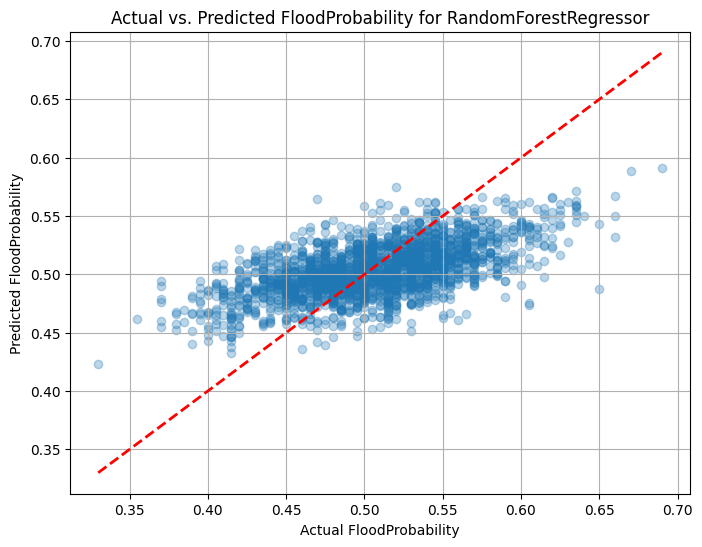

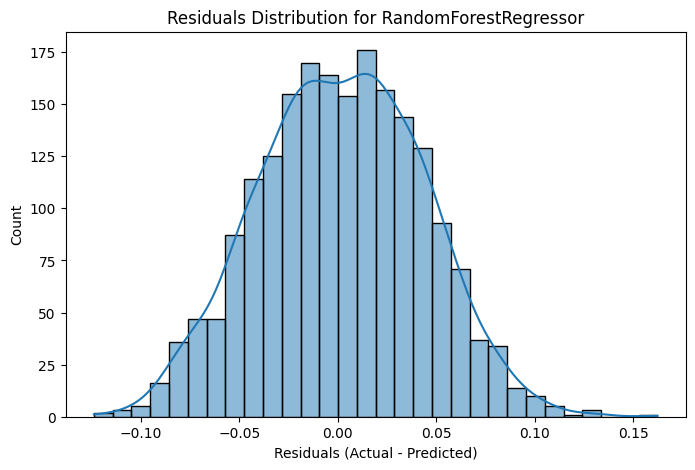

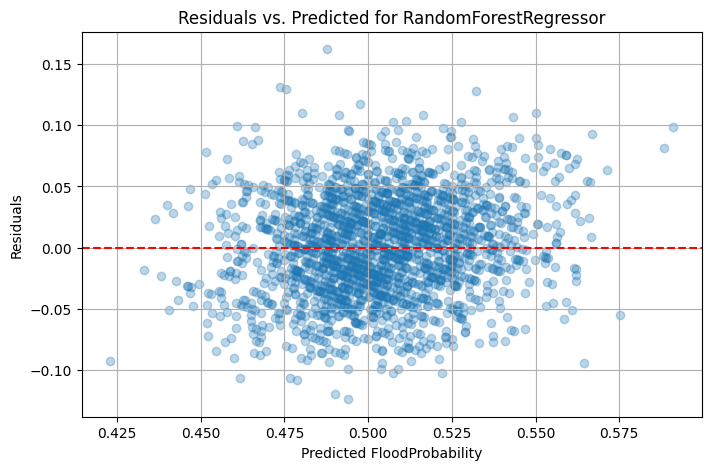


--- Evaluating LGBMRegressor ---
Mean Absolute Error (MAE): 0.0333
Mean Squared Error (MSE): 0.0017
Root Mean Squared Error (RMSE): 0.0409
R-squared (R2): 0.3492


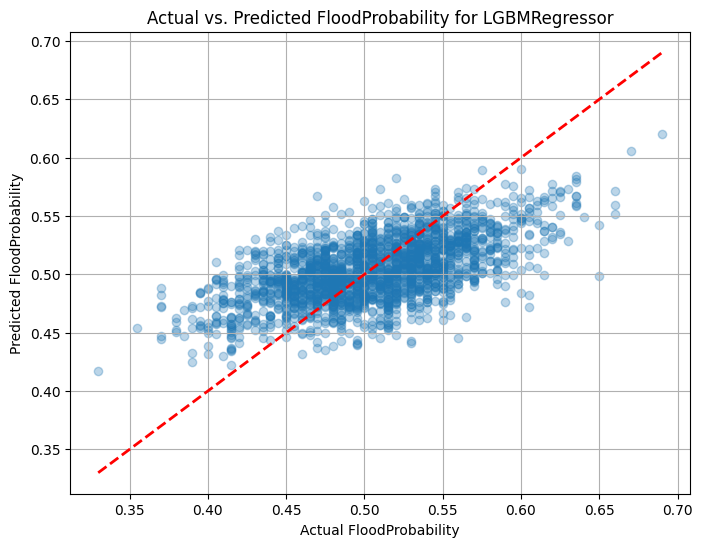

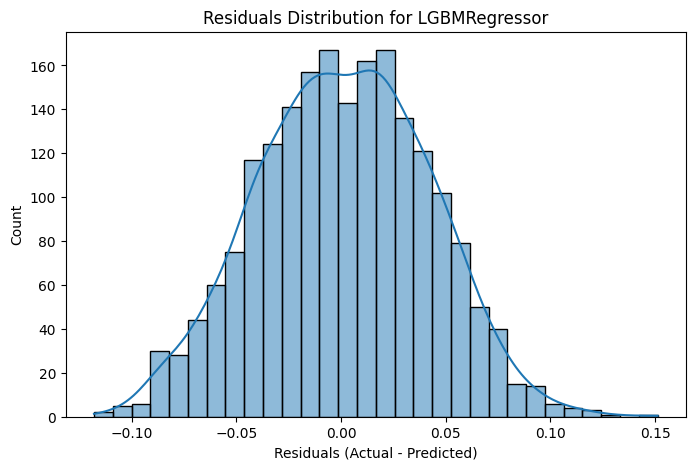

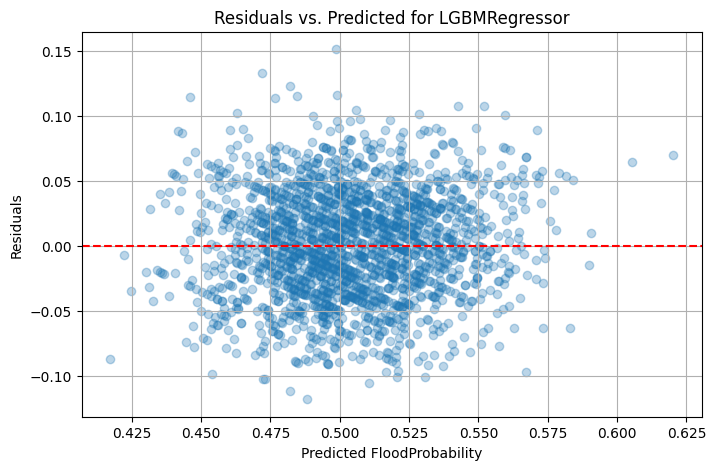


--- Best Regression Model for Prediction: LGBMRegressor (R-squared: 0.3492) ---


In [13]:
# --- 8. Evaluation on Validation Set ---
print("\n--- 8. Evaluation on Validation Set ---")

best_model_name = None
best_r2_score = -np.inf # Initialize with negative infinity for R2 score comparison

for name, model in best_models.items():
    print(f"\n--- Evaluating {name} ---")
    y_pred_val = model.predict(X_val_final)

    # Ensure predictions are within 0-1 range for probabilities
    y_pred_val = np.clip(y_pred_val, 0, 1)

    mae = mean_absolute_error(y_val, y_pred_val)
    mse = mean_squared_error(y_val, y_pred_val)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred_val)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    # Plot Actual vs. Predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_val, y_pred_val, alpha=0.3)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2) # Ideal line
    plt.title(f'Actual vs. Predicted FloodProbability for {name}')
    plt.xlabel('Actual FloodProbability')
    plt.ylabel('Predicted FloodProbability')
    plt.grid(True)
    plt.show()

    # Plot Residuals
    residuals = y_val - y_pred_val
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f'Residuals Distribution for {name}')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred_val, residuals, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residuals vs. Predicted for {name}')
    plt.xlabel('Predicted FloodProbability')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Keep track of the best model based on R-squared
    if r2 > best_r2_score:
        best_r2_score = r2
        best_model_name = name

print(f"\n--- Best Regression Model for Prediction: {best_model_name} (R-squared: {best_r2_score:.4f}) ---")
final_model = best_models[best_model_name]

In [15]:
# --- 9. Prediction on Test Data ---
print("\n--- 9. Making Predictions on Test Data ---")

# Apply the same preprocessing to the test data
test_df_transformed = preprocessor_full.transform(test_df) # Use transform, not fit_transform

# Convert to DataFrame and filter for selected features
test_df_transformed_df = pd.DataFrame(test_df_transformed, columns=all_transformed_features)
X_test_final = test_df_transformed_df[selected_features]

# Make predictions using the final best regression model
test_predictions_raw = final_model.predict(X_test_final)

# Clip predictions to be within the valid probability range [0, 1]
test_predictions_clipped = np.clip(test_predictions_raw, 0, 1)

print("\nPredictions on test data completed.")
print(f"Example predictions (first 5): {test_predictions_clipped[:5]}")
print(f"Min predicted probability: {test_predictions_clipped.min():.4f}")
print(f"Max predicted probability: {test_predictions_clipped.max():.4f}")


--- 9. Making Predictions on Test Data ---

Predictions on test data completed.
Example predictions (first 5): [0.4650483  0.47292609 0.49944606 0.54817488 0.5261788 ]
Min predicted probability: 0.4193
Max predicted probability: 0.6189
